**Variational autoencoder (VAE)**

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set the path for the images

In [0]:
pwd_m = '/content/drive/My Drive/Colab Notebooks/Thesis/data/celeb_faces/male_images/*.jpg'
pwd_f = '/content/drive/My Drive/Colab Notebooks/Thesis/data/celeb_faces/female_images/*.jpg'

Load the related packges

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn import model_selection 

from keras import layers
from keras import Model

Using TensorFlow backend.


**Functions used to do plotting**

The first function is used to plot the 3-channel image and the other one used to plot the images with 1 channel.

In [0]:
# The Function used to plot 3-Channel images
def Plot_Img(n,k,n_c,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k,k,n_c))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
# The Function used to plot 1-Channel images
def Plot_Img_1c(n,k,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k,k))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Read the images and do the training and testing datasets split.

In [0]:
# Read the image from the google drive and display two examples.
img_m = glob.glob(pwd_m)
img_f = glob.glob(pwd_f)

img_names_m = model_selection.train_test_split(img_m)
img_names_f = model_selection.train_test_split(img_f)

im_train_m = np.array([mpimg.imread(a) for a in img_names_m[0]])
im_test_m = np.array([mpimg.imread(a) for a in img_names_m[1]])
im_train_f = np.array([mpimg.imread(a) for a in img_names_f[0]])
im_test_f = np.array([mpimg.imread(a) for a in img_names_f[1]])

im_train_m = im_train_m.astype('float32') / 255.
im_test_m = im_test_m.astype('float32') / 255.
im_train_f = im_train_f.astype('float32') / 255.
im_test_f = im_test_f.astype('float32') / 255.

Plot some examples of the images I use here

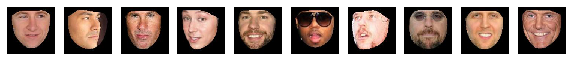

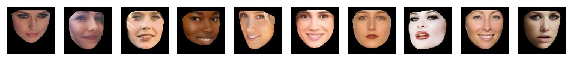

In [7]:
Plot_Img(10,128,3,im_train_m,10,4)
Plot_Img(10,128,3,im_train_f,10,4)

Shape of the training and testing datasets.

In [8]:
im_train = np.concatenate((im_train_m,im_train_f))
im_test = np.concatenate((im_test_m,im_test_f))
print(im_train.shape,im_test.shape)

(750, 128, 128, 3) (250, 128, 128, 3)


**Build up Autoencoder Model with a latent variable layer: A FC layer for encoding**

In [20]:
input_dim = [128,128,3] # The length of the input vector
encode_dim = 2 # The length of the compressed data vector after the encoding

Input = layers.Input(shape=(input_dim[0],input_dim[1],input_dim[2]))
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(Input)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Reshape((16*16,64))(x)
encode = layers.Dense(encode_dim,activation='relu')(x)

x = layers.Reshape((16,16,2))(encode)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
decode = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(x)

simple_auto = Model(Input,decode)
simple_auto.summary()
# Using the 'adam' optimization method with the MSE loss function
simple_auto.compile(optimizer='adam', loss='mean_squared_error') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
__________

Seperate the encoder and the decoder models

In [21]:
# The encoder model
encoder = Model(Input,encode)
# The decoder model
decode_Input = layers.Input(shape=(256,encode_dim))
x = simple_auto.layers[9](decode_Input)
x = simple_auto.layers[10](x)
x = simple_auto.layers[11](x)
x = simple_auto.layers[12](x)
x = simple_auto.layers[13](x)
x = simple_auto.layers[14](x)
x = simple_auto.layers[15](x)
x = simple_auto.layers[16](x)
decoder = Model(decode_Input,x)

print(encoder.summary())
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
__________

**Set up to use the GPU**

In [22]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Training process and testing evaluation

In [23]:
# Train the model
simple_auto.fit(im_train,im_train,epochs=150,batch_size=25)
# Evaluate the test set
simple_auto.evaluate(im_test,im_test)

Epoch 1/150
750/750 [==============================] - 2s 3ms/step - loss: 0.0728
Epoch 2/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0118
Epoch 3/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 4/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 5/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 6/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 7/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 8/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 9/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 10/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 11/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 12/150
750/750 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 13/150


0.0018386491127312184

In [0]:
FC_values_train = encoder.predict(im_train)
decoded_img_train = decoder.predict(FC_values_train)
FC_values_test = encoder.predict(im_test)
decoded_img_test = decoder.predict(FC_values_test)

In [25]:
print(FC_values_train.shape,FC_values_test.shape)

(750, 256, 2) (250, 256, 2)


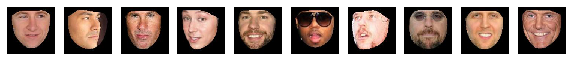

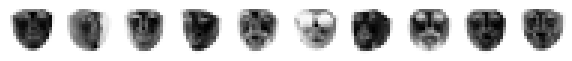

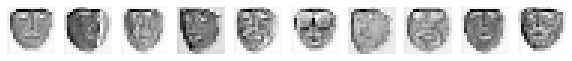

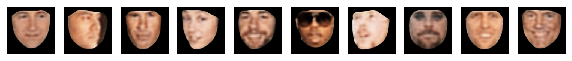

In [26]:
FC_values_train1 = FC_values_train[:,:,0]
FC_values_train2 = FC_values_train[:,:,1]
Plot_Img(10,128,3,im_train,10,4)
Plot_Img_1c(10,16,FC_values_train1,10,4)
Plot_Img_1c(10,16,FC_values_train2,10,4)
Plot_Img(10,128,3,decoded_img_train,10,4)

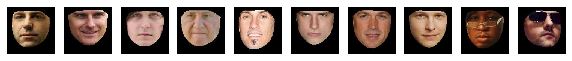

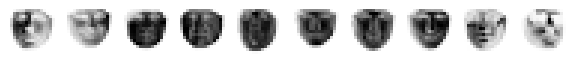

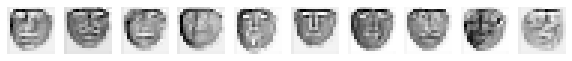

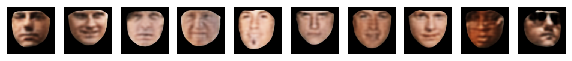

In [27]:
FC_values_test1 = FC_values_test[:,:,0]
FC_values_test2 = FC_values_test[:,:,1]
Plot_Img(10,128,3,im_test,10,4)
Plot_Img_1c(10,16,FC_values_test1,10,4)
Plot_Img_1c(10,16,FC_values_test2,10,4)
Plot_Img(10,128,3,decoded_img_test,10,4)